In [1]:
import pandas as pd
import numpy as np
from PIL import Image
import random
import matplotlib.pyplot as plt  
from scipy.stats import norm  
import keras
from keras.models import Sequential
from keras.initializers import VarianceScaling,RandomNormal
from keras.layers import Input, Dense, Dropout, Conv2D, MaxPooling2D
from keras.layers import UpSampling2D, Reshape, Lambda, Flatten, Activation
from keras.models import Model  
from keras.optimizers import SGD, Adadelta, Adagrad,Adam
from keras import backend as K  
from keras import objectives  
from keras.utils.vis_utils import plot_model  
from keras.utils import np_utils, generic_utils
import sys 
import tensorflow as tf
from keras.callbacks import TensorBoard, ModelCheckpoint
from keras.layers.normalization import BatchNormalization
import matplotlib.pyplot as plt
import os
#os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import sklearn
from mpl_toolkits.mplot3d import Axes3D
%matplotlib inline
from sklearn import manifold, datasets
from sklearn.utils import check_random_state

Using TensorFlow backend.


In [2]:
path = os.listdir('cstor/xsede/users/xs-haosun/SDSS_2000/')

In [3]:
Obj_ID = []
Image = []
Class = []
Redshift = []
for i in range(len(path)):
    path_now = path[i]
    a = np.load('cstor/xsede/users/xs-haosun/SDSS_2000/'+str(path_now))
    for j in range(a.shape[0]):
        Obj_ID.append(a[j]['objID'])
        Image.append(a[j]['image'])
        Class.append(a[j]['class'])
        Redshift.append(a[j]['z'])

In [4]:
Obj_ID = np.asarray(Obj_ID)
Image = np.asarray(Image)
Class = np.asarray(Class)
Redshift = np.asarray(Redshift)
Class[Class=='STAR'] = 0
Class[Class=='GALAXY'] = 1
Class[Class=='QSO'] = 2
Class = Class.astype(int)

In [5]:
Image_RGB = np.empty((len(Image),64,64,3))#(14142,64,64,3) RGB images
for i in range(len(Image)):
    #b[i] = np.stack((a[i][1][0],a[i][1][1],a[i][1][2],a[i][1][3],a[i][1][4]),axis=-1)
    Image_RGB[i] = np.stack((Image[i][3],Image[i][2],Image[i][1]),axis=-1)


In [6]:
for i in range(len(Image_RGB)):
    if True in np.isnan(Image_RGB[i]).reshape(64*64*3):
        print(i)
        Image_RGB[i][np.isnan(Image_RGB[i])==True]=0

815


In [7]:
Image_RGB -= np.mean(Image_RGB)
Image_RGB /= np.max(Image_RGB)

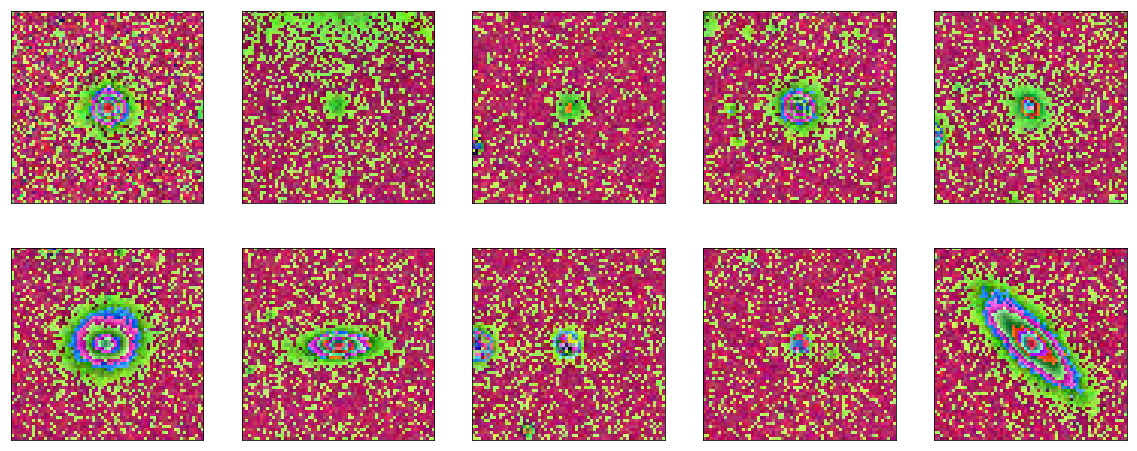

[1 1 1 1 1 1 1 0 2 1]


In [8]:
n=5
plt.figure(figsize=(20, 20*2/5))
for l in range(2):
    for i in range(n):
        ax = plt.subplot(2,n,l*n+i+1)
        plt.imshow((Image_RGB[10+l*5+i]))
        ax.get_xaxis().set_visible(False)
        ax.get_yaxis().set_visible(False)
plt.show()
print(Class[10:20])

In [9]:
label = np_utils.to_categorical(Class, 3)

In [10]:
data = Image_RGB

In [11]:
train_data = data
train_label = label
print('train_data.shape:',train_data.shape)
print('train_label.shape:',train_label.shape)
index = [i for i in range(len(train_data))]
#random.shuffle(index)
train_data = train_data[index]
train_label = train_label[index]
print('total ',train_data.shape[0], ' samples')

train_data.shape: (14142, 64, 64, 3)
train_label.shape: (14142, 3)
total  14142  samples


In [80]:
batch_size =100
latent_dim = 2
nb_epoch = 50  
epsilon_std = 1.0  
intermediate_dim_1 = 600
intermediate_dim_2 = 200
original_dim = 64*64

input_img = Input(shape=(64,64,3))

conv_1 = Conv2D(20, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(input_img)
maxpool_1 = MaxPooling2D((2, 2),  padding='same')(conv_1)

conv_2 = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(maxpool_1)
maxpool_2 = MaxPooling2D((2, 2),  padding='same')(conv_2)

conv_3 = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(maxpool_2)
maxpool_3 = MaxPooling2D((2, 2),  padding='same')(conv_3)

conv_4 = Conv2D(80, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(maxpool_3)
maxpool_4 = MaxPooling2D((2, 2),  padding='same')(conv_4)

conv_5 = Conv2D(80, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(maxpool_4)
maxpool_5 = MaxPooling2D((2, 2),  padding='same')(conv_5)

#x = Conv2D(5, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(x)
#x = MaxPooling2D((2, 2),  padding='same')(x)

visual = Flatten()(maxpool_5)
h_1 = Dense(intermediate_dim_1, activation='tanh')(visual)
h_2 = Dense(intermediate_dim_2, activation='tanh')(h_1)

z_mean = Dense(latent_dim)(h_2)
z_log_var = Dense(latent_dim)(h_2)

def sampling(args):   
    z_mean, z_log_var = args  
    epsilon = K.random_normal(shape=(batch_size, latent_dim), mean=0.,stddev=epsilon_std)
    return z_mean + K.exp(z_log_var / 2)* epsilon

z = Lambda(sampling, output_shape=(latent_dim,))([z_mean, z_log_var])

h_3 = Dense(intermediate_dim_2,activation='tanh')(z)
h_4 = Dense(intermediate_dim_1,activation='relu')(h_3)
h_5 = Dense(80*2*2,activation='relu')(h_4)
h_6 = Reshape((2,2,80))(h_5)


conv_6 = Conv2D(80, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(h_6)
upsample_6 = UpSampling2D((2, 2))(conv_6)

conv_7 = Conv2D(80, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(upsample_6)
upsample_7 = UpSampling2D((2, 2))(conv_7)

conv_8 = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(upsample_7)
upsample_8 = UpSampling2D((2, 2))(conv_8)

conv_9 = Conv2D(40, (3, 3), activation='relu', padding='same',kernel_initializer='normal')(upsample_8)
upsample_9 = UpSampling2D((2, 2))(conv_9)

conv_10 = Conv2D(20,  (3, 3), activation='tanh',padding='same',kernel_initializer='normal')(upsample_9)
upsample_10 = UpSampling2D((2, 2))(conv_10)

decoded = Conv2D(3, (3, 3), activation='tanh', padding='same')(upsample_10)

EarlyStopping = keras.callbacks.EarlyStopping(monitor='val_loss', min_delta=0, patience=10, verbose=0, mode='auto')


def vae_loss(x, decoded):  
    xent_loss = K.sum(K.sum(objectives.binary_crossentropy(x ,decoded),axis=-1),axis=-1)
    kl_loss = - 0.5 * K.sum(1 + z_log_var - K.square(z_mean) - K.exp(z_log_var), axis=-1) 
    return xent_loss + 1*kl_loss  


vae = Model(inputs=input_img, outputs=decoded) 
vae.compile(optimizer='rmsprop', loss=vae_loss) 



In [81]:
vae.fit(train_data[:8000], train_data[:8000],  
        shuffle=True,  
        epochs=20,    
        batch_size=batch_size,  
        validation_data=(train_data[8000:8500],train_data[8000:8500]),callbacks=[EarlyStopping])  

Train on 8000 samples, validate on 500 samples
Epoch 1/20
8000/8000 [==============================] - 8s - loss: -7273.6829 - val_loss: -7608.6013
Epoch 2/20
8000/8000 [==============================] - 7s - loss: -7661.1057 - val_loss: -7829.2706
Epoch 3/20
8000/8000 [==============================] - 7s - loss: -7834.5934 - val_loss: -7829.5294
Epoch 4/20
8000/8000 [==============================] - 7s - loss: -7878.7117 - val_loss: -7894.5343
Epoch 5/20
8000/8000 [==============================] - 7s - loss: -7932.8418 - val_loss: -7934.1019
Epoch 6/20
8000/8000 [==============================] - 7s - loss: -7947.8158 - val_loss: -7898.3116
Epoch 7/20
8000/8000 [==============================] - 7s - loss: -7942.9491 - val_loss: -7958.2058
Epoch 8/20
8000/8000 [==============================] - 7s - loss: -7946.6382 - val_loss: -7924.7609
Epoch 9/20
8000/8000 [==============================] - 7s - loss: -7964.3543 - val_loss: -7914.1983
Epoch 10/20
8000/8000 [=====================

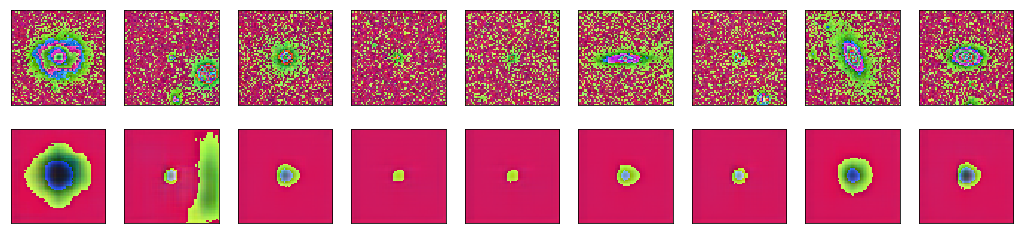

In [82]:
# encode and decode some digits
# note that we take them from the *test* set
# use Matplotlib (don't ask)
import matplotlib.pyplot as plt

#encoded_imgs = encoder.predict(x_test)

decoded_imgs = vae.predict(train_data[8000:9000],batch_size=100)

n = 10  # how many digits we will display
plt.figure(figsize=(20, 4))
for i in range(1,n):
    # display original
    ax = plt.subplot(2,n,i)
    plt.imshow((train_data[8000:9000][i]))
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    # display reconstruction
    ax = plt.subplot(2, n ,i + n)
    plt.imshow((decoded_imgs[i]))
    #plt.gray()
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
plt.show()

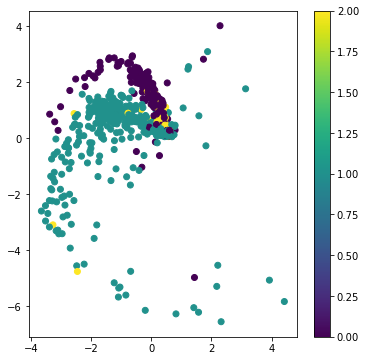

In [83]:
label_value = np.zeros(len(train_label))
for i in range(len(label_value)):
    label_value[i] =np.argmax(train_label[i])

vis = Model(input_img, z_mean)

# display a 2D plot of the digit classes in the latent space  
x_vis = vis.predict(train_data[8000:9000], batch_size=batch_size)  
plt.figure(figsize=(6, 6))
plt.scatter( x_vis[:, 0] ,x_vis[:, 1],c=label_value[8000:9000])
plt.colorbar()
plt.show()

Automatically created module for IPython interactive environment
standard: 0.16 sec
modified: 0.29 sec
Isomap: 0.5 sec
MDS: 1.7 sec
SpectralEmbedding: 0.11 sec
t-SNE: 3.3 sec


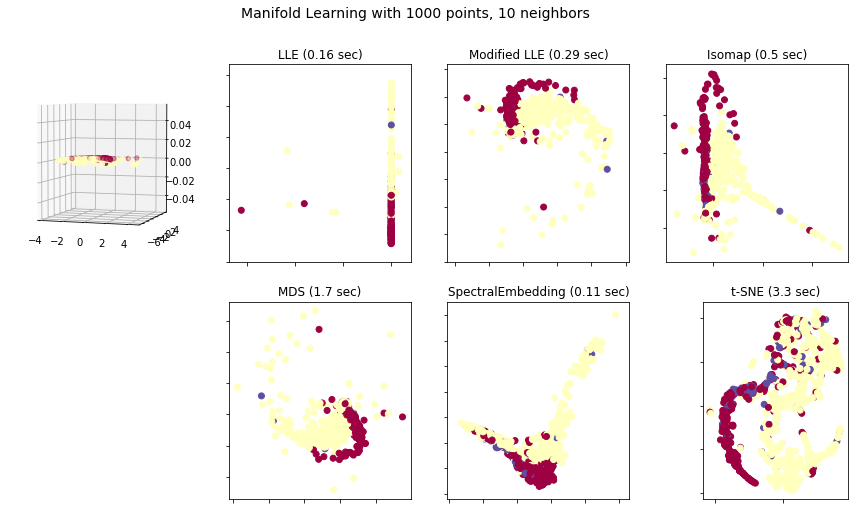

In [84]:
# Author: Jake Vanderplas -- <vanderplas@astro.washington.edu>

print(__doc__)

from time import time
from sklearn import cluster
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib.ticker import NullFormatter

from sklearn import manifold, datasets

# Next line to silence pyflakes. This import is needed.
Axes3D

n_points = 1000
X = np.asarray(x_vis,dtype='float64')
color = label_value[8000:9000]
#X, color = datasets.samples_generator.make_s_curve(n_points, random_state=0)
#X = X.astype(np.float32)
n_neighbors = 10
n_components = 2

fig = plt.figure(figsize=(15, 8))
plt.suptitle("Manifold Learning with %i points, %i neighbors"
             % (1000, n_neighbors), fontsize=14)

try:
    # compatibility matplotlib < 1.0
    ax = fig.add_subplot(241, projection='3d')
    ax.scatter(X[:, 0], X[:, 1], c=color, cmap=plt.cm.Spectral)
    ax.view_init(4, -72)
except:
    ax = fig.add_subplot(241, projection='3d')
    plt.scatter(X[:, 0], X[:, 1], c=color, cmap=plt.cm.Spectral)

methods = ['standard', 'modified']
labels = ['LLE', 'Modified LLE']

for i, method in enumerate(methods):
    t0 = time()
    Y = manifold.LocallyLinearEmbedding(n_neighbors, n_components,
                                        eigen_solver='auto',
                                        method=method).fit_transform(X)
    t1 = time()
    print("%s: %.2g sec" % (methods[i], t1 - t0))

    ax = fig.add_subplot(242 + i)
    plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
    plt.title("%s (%.2g sec)" % (labels[i], t1 - t0))
    ax.xaxis.set_major_formatter(NullFormatter())
    ax.yaxis.set_major_formatter(NullFormatter())
    plt.axis('tight')

t0 = time()
Y = manifold.Isomap(n_neighbors, n_components).fit_transform(X)
t1 = time()
print("Isomap: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(244)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("Isomap (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')


t0 = time()
mds = manifold.MDS(n_components, max_iter=100, n_init=1)
Y = mds.fit_transform(X)
t1 = time()
print("MDS: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(246)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("MDS (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')


t0 = time()
se = manifold.SpectralEmbedding(n_components=n_components,
                                n_neighbors=n_neighbors)
Y = se.fit_transform(X)
t1 = time()
print("SpectralEmbedding: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(247)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("SpectralEmbedding (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

t0 = time()
tsne = manifold.TSNE(n_components=n_components, init='pca', random_state=0)
Y = tsne.fit_transform(X)
t1 = time()
print("t-SNE: %.2g sec" % (t1 - t0))
ax = fig.add_subplot(2, 5, 10)
plt.scatter(Y[:, 0], Y[:, 1], c=color, cmap=plt.cm.Spectral)
plt.title("t-SNE (%.2g sec)" % (t1 - t0))
ax.xaxis.set_major_formatter(NullFormatter())
ax.yaxis.set_major_formatter(NullFormatter())
plt.axis('tight')

plt.show()

In [102]:
import scipy
from scipy import misc
import numpy as np
a = [[1,2],[3,4]],[[5,6],[7,8]]
np.shape(a)
#a = np.asarray(a)
scipy.misc.imresize(a[1],size=(4,4),mode="F", interp='bilinear')

array([[ 5.  ,  5.25,  5.75,  6.  ],
       [ 5.5 ,  5.75,  6.25,  6.5 ],
       [ 6.5 ,  6.75,  7.25,  7.5 ],
       [ 7.  ,  7.25,  7.75,  8.  ]], dtype=float32)

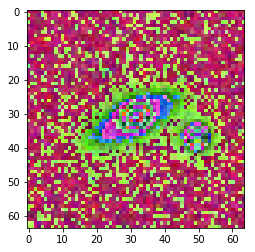

In [93]:
plt.imshow(train_data[0])
plt.show()

In [86]:
model_conv_1 = Model(input_img,conv_1)
model_pool_1 = Model(input_img,maxpool_1)
model_conv_2 = Model(input_img,conv_2)
model_pool_2 = Model(input_img,maxpool_2)
model_conv_3 = Model(input_img,conv_3)
model_pool_3 = Model(input_img,maxpool_3)
model_conv_4 = Model(input_img,conv_4)
model_pool_4 = Model(input_img,maxpool_4)
model_conv_5 = Model(input_img,conv_5)
model_pool_5 = Model(input_img,maxpool_5)
model_conv_6 = Model(input_img,conv_6)
model_up_6 = Model(input_img,upsample_6)
model_conv_7 = Model(input_img,conv_7)
model_up_7 = Model(input_img,upsample_7)
model_conv_8 = Model(input_img,conv_8)
model_up_8 = Model(input_img,upsample_8)
model_conv_9 = Model(input_img,conv_9)
model_up_9 = Model(input_img,upsample_9)
model_conv_10 = Model(input_img,conv_10)
model_up_10 = Model(input_img,upsample_10)

In [98]:
model_conv_2.predict(train_data[0:1000],batch_size=10).shape[:]

(1000, 32, 32, 40)

In [112]:
lyr = []
lyr.append(model_conv_1)
lyr.append(model_pool_1)
lyr.append(model_conv_2)
lyr.append(model_pool_2)
lyr.append(model_conv_3)
lyr.append(model_pool_3)
lyr.append(model_conv_4)
lyr.append(model_pool_4)
lyr.append(model_conv_5)
lyr.append(model_pool_5)
lyr.append(model_conv_6)
lyr.append(model_up_6)
lyr.append(model_conv_7)
lyr.append(model_up_7)
lyr.append(model_conv_8)
lyr.append(model_up_8)
lyr.append(model_conv_9)
lyr.append(model_up_9)
lyr.append(model_conv_10)
lyr.append(model_up_10)

In [124]:
lyr[0].output_shape[3]

20

In [173]:
#use the No_ th figure
No_ = 4
hypercolumns = []
for i in range(np.shape(lyr)[0]):
    for l in range(lyr[i].output_shape[3]):
        hypercolumns.append(scipy.misc.imresize(lyr[i].predict(train_data[0:100],batch_size=100)[No_,:,:,l],size=(64,64),mode="F", interp='bilinear'))

In [176]:
hypercolumns = np.asarray(hypercolumns)
m=hypercolumns.transpose(1,2,0).reshape(64*64,-1)
kmeans = cluster.KMeans(n_clusters=4, max_iter=300, n_jobs=1, precompute_distances=True)
cluster_labels = kmeans.fit_predict(m)

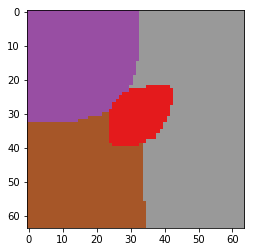

In [177]:
imcluster = np.zeros((64,64))
imcluster = imcluster.reshape((64*64,))
imcluster = cluster_labels
plt.imshow(imcluster.reshape(64, 64), cmap="Set1")

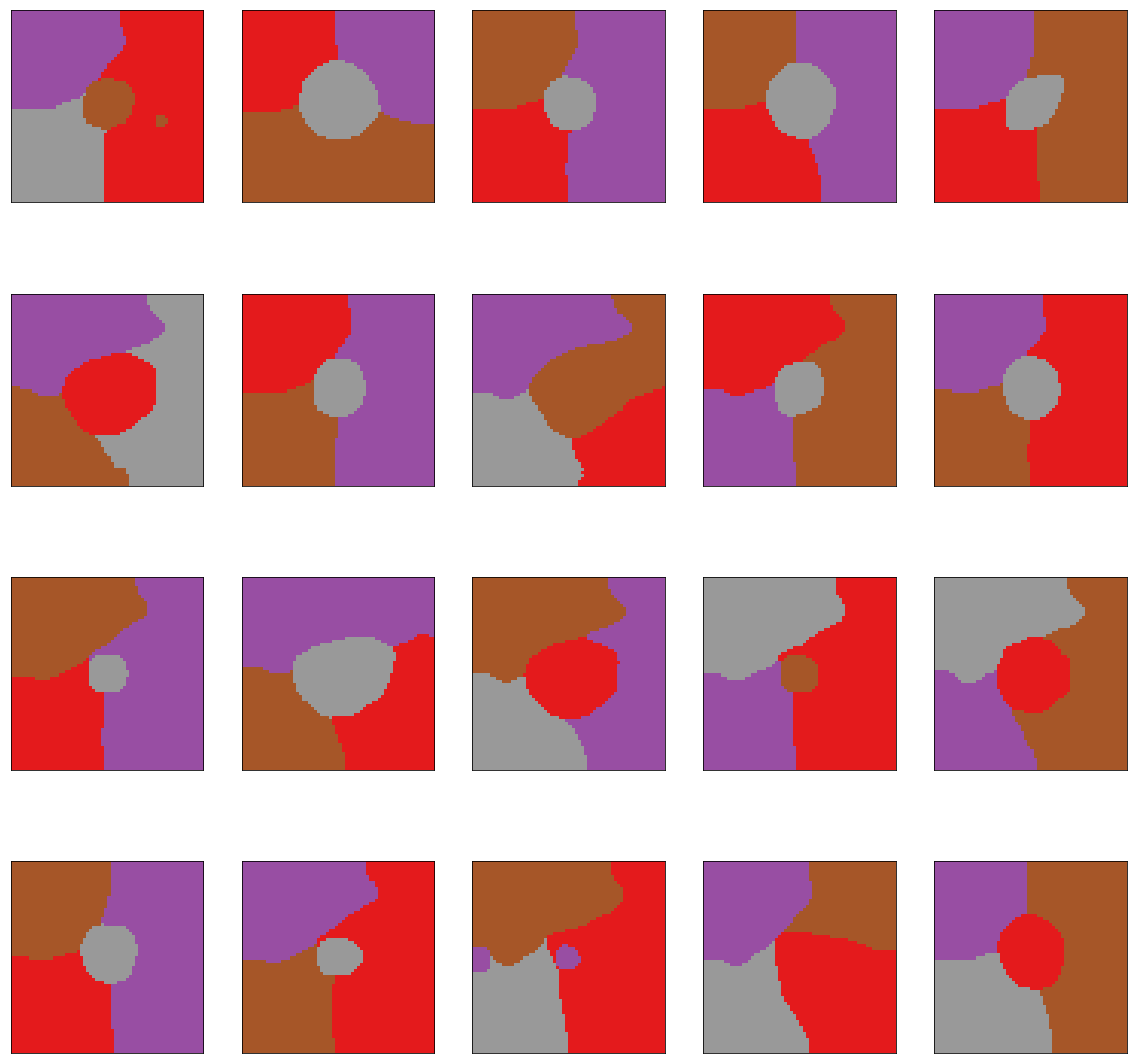

In [185]:
plt.figure(figsize=(20, 20))
for number in range(20):
    No_ = number
    hypercolumns = []
    for i in range(np.shape(lyr)[0]):
        for l in range(lyr[i].output_shape[3]):
            hypercolumns.append(scipy.misc.imresize(lyr[i].predict(train_data[0:100],batch_size=100)[No_,:,:,l],size=(64,64),mode="F", interp='bilinear'))
    
    hypercolumns = np.asarray(hypercolumns)
    m=hypercolumns.transpose(1,2,0).reshape(64*64,-1)
    kmeans = cluster.KMeans(n_clusters=4, max_iter=300, n_jobs=1, precompute_distances=True)
    cluster_labels = kmeans.fit_predict(m)
    
    imcluster = np.zeros((64,64))
    imcluster = imcluster.reshape((64*64,))
    imcluster = cluster_labels
    
    ax = plt.subplot(4,5,number+1)
    plt.imshow(imcluster.reshape(64, 64), cmap="Set1")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    
plt.show()

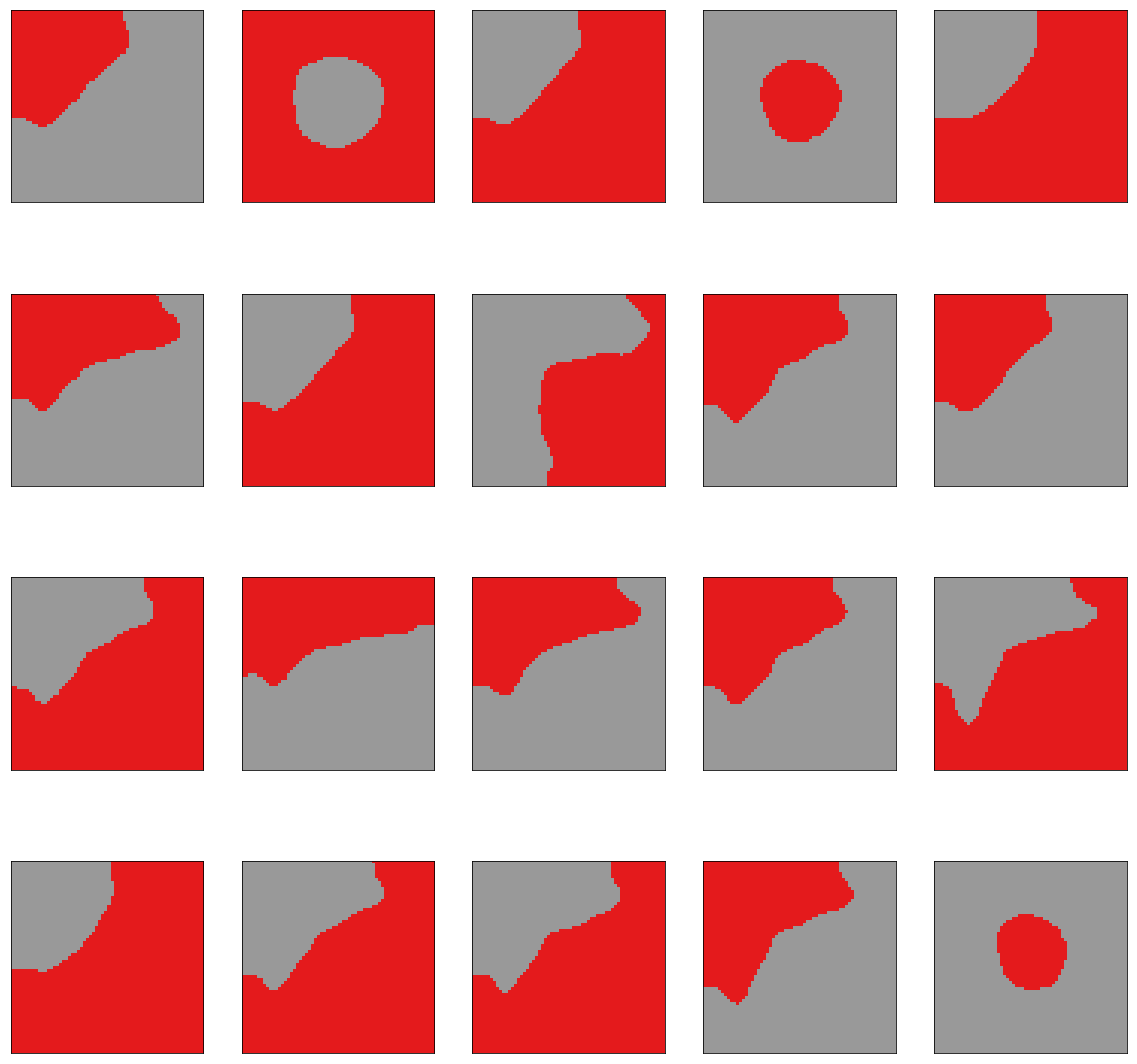

In [186]:
fig = plt.figure(figsize=(20, 20))
for number in range(20):
    No_ = number
    hypercolumns = []
    for i in range(np.shape(lyr)[0]):
        for l in range(lyr[i].output_shape[3]):
            hypercolumns.append(scipy.misc.imresize(lyr[i].predict(train_data[0:100],batch_size=100)[No_,:,:,l],size=(64,64),mode="F", interp='bilinear'))
    
    hypercolumns = np.asarray(hypercolumns)
    m=hypercolumns.transpose(1,2,0).reshape(64*64,-1)
    kmeans = cluster.KMeans(n_clusters=2, max_iter=300, n_jobs=1, precompute_distances=True)
    cluster_labels = kmeans.fit_predict(m)
    
    imcluster = np.zeros((64,64))
    imcluster = imcluster.reshape((64*64,))
    imcluster = cluster_labels
    ax = plt.subplot(4,5,number+1)
    plt.imshow(imcluster.reshape(64, 64), cmap="Set1")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
    
plt.show()

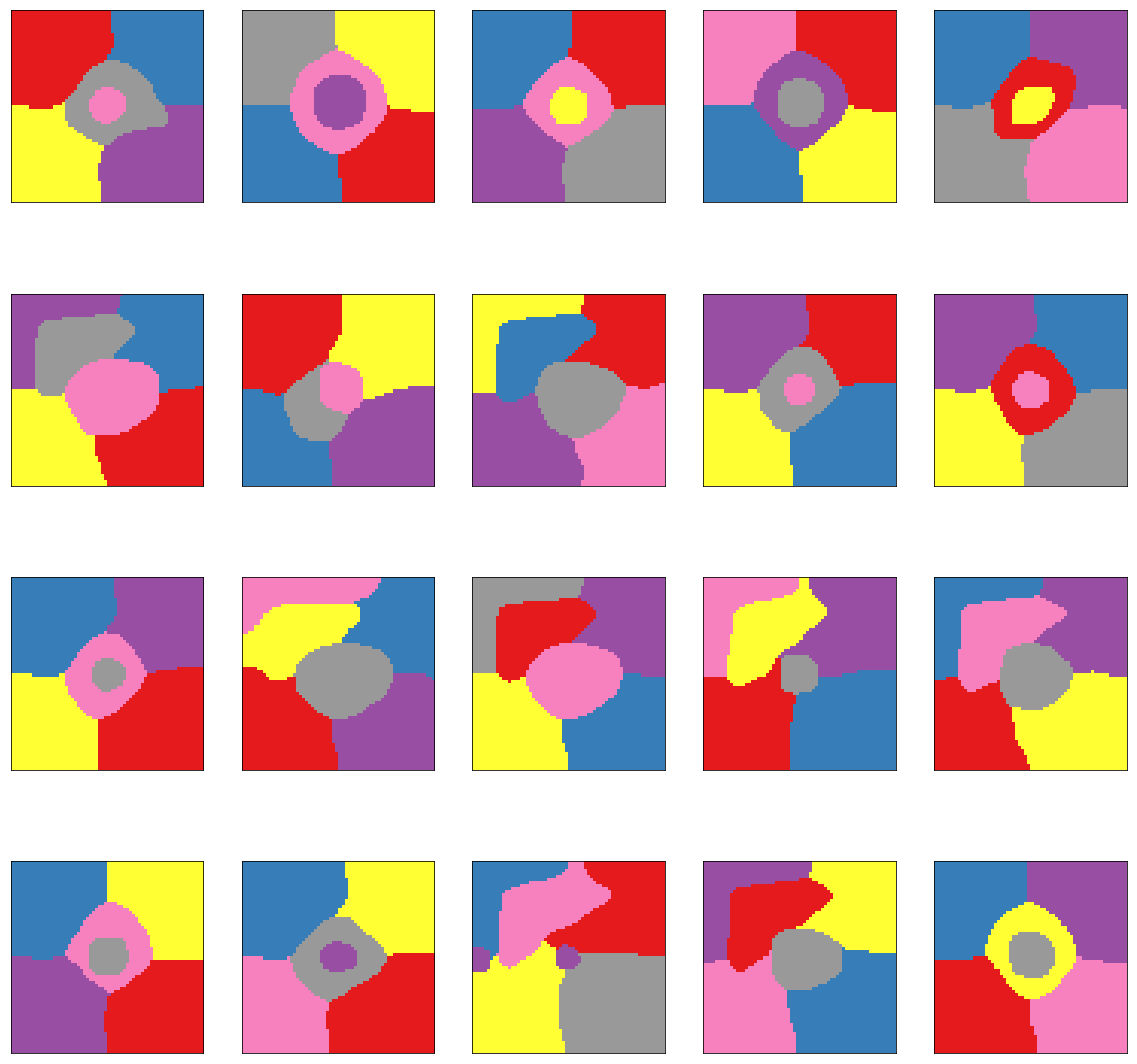

In [187]:
plt.figure(figsize=(20, 20))
for number in range(20):
    No_ = number
    hypercolumns = []
    for i in range(np.shape(lyr)[0]):
        for l in range(lyr[i].output_shape[3]):
            hypercolumns.append(scipy.misc.imresize(lyr[i].predict(train_data[0:100],batch_size=100)[No_,:,:,l],size=(64,64),mode="F", interp='bilinear'))
    
    hypercolumns = np.asarray(hypercolumns)
    m=hypercolumns.transpose(1,2,0).reshape(64*64,-1)
    kmeans = cluster.KMeans(n_clusters=6, max_iter=300, n_jobs=1, precompute_distances=True)
    cluster_labels = kmeans.fit_predict(m)
    
    imcluster = np.zeros((64,64))
    imcluster = imcluster.reshape((64*64,))
    imcluster = cluster_labels
    
    ax = plt.subplot(4,5,number+1)
    plt.imshow(imcluster.reshape(64, 64), cmap="Set1")
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

    
plt.show()